# GOAL
Using xHMM to find CNV in chromosome 5 of sWGA field isolates.

In [17]:
import os
import os
import glob
import re
import pandas
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from hmmlearn import hmm
import scipy.stats
# from sklearn import hmm
%matplotlib inline

In [ ]:
PF_FIELD_GDNA_COV_DIR = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output"
xHMM_OUT_TSV = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.chr5.xcnv.win300.tsv"
SAMPLE_MAP_CSV = "/Volumes/nfs/users/nfs_t/tn6/gitrepo/pf_swga_cnv/data/sWGA_plexing_sample_map.csv"
PYSAM_DIR = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv_wgs/output/pysamstats_gc"
GAUSSIAN_HMM_DIR = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv_wgs/output/gaussian_hmm_cnv"

In [91]:
loadings_std_tsv = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.RD_PCA.PC_SD.txt"

Take a look at the xHMM Principal Components of the sWGA samples

In [93]:
loadings_std = pandas.read_csv(loadings_std_tsv, delimiter="\t")
# loadings = loadings.transpose()
# loadings = loadings.set_index("U_T")
# loadings = loadings.transpose()
display(loadings_std.head())
display(loadings_std.shape)
display(loadings_std.describe())
# loadings = loadings.astype(float)

,D,SD
0,PC1,61238.151723
1,PC2,54492.375506
2,PC3,31646.061986
3,PC4,22800.477153
4,PC5,18780.689605


(37, 2)

,SD
count,37.000000
mean,11198.623079
std,12930.503481
min,0.000005
25%,4634.808713
50%,6327.329122
75%,12396.042280
max,61238.151723


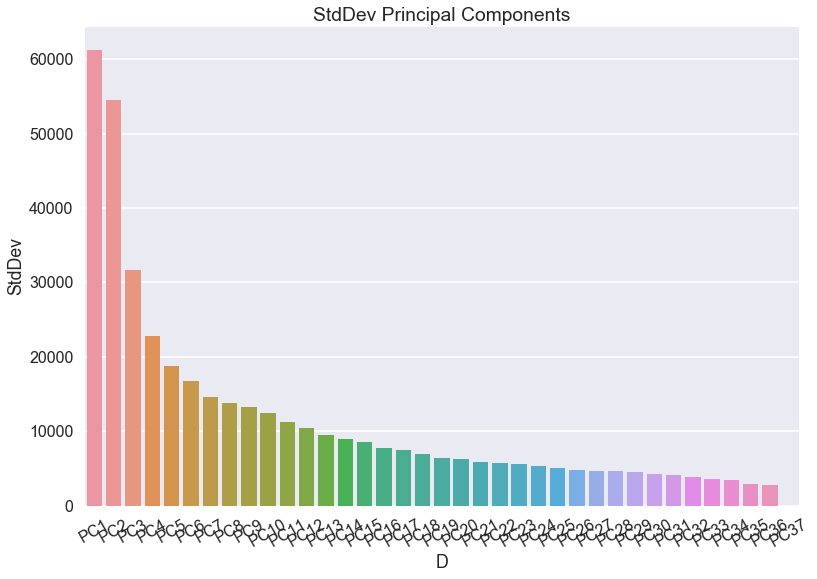

In [94]:
sns.set_context("poster")
ax = sns.barplot(x="D", y="SD", data=loadings_std)
sns.plt.title("StdDev Principal Components")
ax.set_ylabel("StdDev")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

In [68]:
xhmm_out = pandas.read_csv(xHMM_OUT_TSV, sep="\t")
xhmm_out

,sample,window,copy_number
0,PF1155-CW,209400,2
1,PF1155-CW,209700,2
2,PF1155-CW,210000,2
3,PF1155-CW,210300,2
4,PF1155-CW,210600,2
5,PF1155-CW,210900,2
6,PF1155-CW,211200,2
7,PF1155-CW,211500,2
8,PF1155-CW,211800,2
9,PF1155-CW,212100,2


In [69]:
sample_map = pandas.read_csv(SAMPLE_MAP_CSV, sep=",")
sample_map

,oxford_code_swga_X10,oxford_code_swga_HiSeq2000,oxford_code_wgs_Hiseq2000,seqscape_name_swga_X10,seqscape_name_swga_HiSeq2000,seqscape_name_wgs_Hiseq2000,parasitemia,experiment_swga_X10
0,PF1170-CW,PF1170-C,PF1170-Cx,3429STDY6404057,3910STDY6216486,3909STDY6204234,4.803000,12_16h
1,PF1141-CW,PF1141-C,PF1141-Cx,3429STDY6404058,3910STDY6216476,3909STDY6204224,1.373500,12_16h
2,PF1195-CW,PF1195-C,PF1195-Cx,3429STDY6404059,3910STDY6216504,3909STDY6204252,0.165000,12_16h
3,PF1188-CW,PF1188-C,PF1188-Cx,3429STDY6404060,3910STDY6216500,3909STDY6204248,2.849000,12_16h
4,PF1061-CxW,PF1061-Cx,PF1061-C,3429STDY6404061,CR43,3061STDY5801218,0.883725,12_16h
5,PF1075-CxW,PF1075-Cx,PF1075-C,3429STDY6404062,CR36,3061STDY5801235,0.318800,12_16h
6,PF1020-CxW,PF1020-Cx,PF1020-C,3429STDY6404063,CR23,3061STDY5801270,1.176700,12_16h
7,PF1010-CxW,PF1010-Cx,PF1010-C,3429STDY6404064,CR12-t20,3061STDY5801190,0.229000,12_16h
8,PF1131-CW,PF1131-C,PF1131-Cx,3429STDY6404065,3910STDY6216468,3909STDY6204216,3.233200,12_16h
9,PF1175-CW,PF1175-C,PF1175-Cx,3429STDY6404066,3910STDY6216491,3909STDY6204239,2.209500,12_16h


In [70]:
xhmm_out_map = xhmm_out.set_index("sample").join(
    sample_map[["oxford_code_swga_X10", "seqscape_name_wgs_Hiseq2000"]].set_index("oxford_code_swga_X10"))
xhmm_out_map.index.name = "sample"
display(xhmm_out_map.head())
display(xhmm_out_map.describe())

,window,copy_number,seqscape_name_wgs_Hiseq2000
sample,,,
PF1010-CxW,209700,2,3061STDY5801190
PF1010-CxW,210000,2,3061STDY5801190
PF1010-CxW,210300,2,3061STDY5801190
PF1010-CxW,210600,2,3061STDY5801190
PF1010-CxW,210900,2,3061STDY5801190


,window,copy_number
count,3.602000e+03,3602.000000
mean,6.661622e+05,1.170461
std,3.996745e+05,0.985501
min,2.700000e+04,0.000000
25%,2.166000e+05,0.000000
50%,7.020000e+05,2.000000
75%,1.036725e+06,2.000000
max,1.333500e+06,2.000000


In [12]:

def fit_hmm(depth_normed,  # normalised coverage array 
            transition_probability,  # probability of state transition
            variance,  # variance per copy 
            variance_fixed,  # variance for the zero copy number state 
            min_swga_copy_number=0,  # minimum copy number to consider in the model
            max_swga_copy_number=5,  # maximum copy number to consider in the model 
            n_iter=0,  # number of iterations to perform when fitting the model
            params='st',  # parameters that can be changed through fitting 
            init_params='',  # parameters that are initialised from the data
           ):
    
    # convenience variable
    n_states = max_swga_copy_number - min_swga_copy_number
    
    # construct the transition matrix
    transmat = np.zeros((n_states, n_states))
    transmat[:] = transition_probability
    transmat[np.diag_indices(n_states)] = 1-((n_states-1)*transition_probability)
    display("transmat")
    display(transmat)

    # construct means and covariance
    means = np.array([[n] for n in range(min_swga_copy_number, max_swga_copy_number)])
    covars = np.array([[variance*n + variance_fixed] for n in range(min_swga_copy_number, max_swga_copy_number)])

    # setup HMM 
    model = hmm.GaussianHMM(n_states, 
                        covariance_type='diag', 
                        n_iter=n_iter, 
                        transmat_prior=transmat, 
                        params=params,
                        init_params=init_params)
    model.means_ = means
    model.covars_ = covars
    
    # fit HMM
    obs = np.column_stack([depth_normed])
    display("obs")
    display(obs)
#     obs = depth_normed
    model.fit(obs)
    
    # predict hidden states
    h = model.predict(obs)
    
    return h

# Field Isolate WGS Copy Number Calls from Gaussian HMM on GC Normalized Coverage

In [41]:
def get_hmm_cnv_calls(calls_dir):
    sample_stats_list = []
    # Expect <sample>.<library>.<lane>.cnv.tsv
    for i, cnv_call_tsv in enumerate(glob.glob(calls_dir + os.sep + "*cnv.tsv")):
        
        sample_stats = pandas.read_csv(cnv_call_tsv, sep="\t", 
                                  comment="#", skip_blank_lines=True)
        
        sample, library, lane = os.path.basename(cnv_call_tsv).split(".")[:3]
        sample_stats["sample"] = sample
        sample_stats["library"] = library
        sample_stats["lane"] = lane
        if not lane.startswith("20295_4"):
            continue
#         display(sample_stats)
        
#         if i > 2:
#             break
            
        sample_stats_list.append(sample_stats)


    all_samples_metrics = pandas.concat(sample_stats_list)
    return all_samples_metrics

In [71]:
cnv_calls = get_hmm_cnv_calls(GAUSSIAN_HMM_DIR)
display(cnv_calls.shape)
display(cnv_calls.head())
display(cnv_calls.tail())
display(cnv_calls.describe())

(157058, 12)

,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,sample,window
0,0,20.0,26.397351,26.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,PF1092-CxW,900.0
1,0,30.0,31.765182,32.0,20295_4_36,16880631,0.033027,44.743370,1.477733,1.0,PF1092-CxW,1200.0
2,0,30.0,32.420455,32.0,20295_4_36,16880631,0.022350,44.743370,1.000000,1.0,PF1092-CxW,1500.0
3,0,20.0,27.816176,28.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,PF1092-CxW,1800.0
4,0,20.0,27.446809,27.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,PF1092-CxW,2100.0


,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,sample,window
4391,0,20.0,27.391892,27.0,20295_4_8,16880558,0.016930,89.398420,1.513514,2.0,PF1134-CW,1341600.0
4392,0,20.0,27.536667,28.0,20295_4_8,16880558,0.029419,89.398420,2.630000,3.0,PF1134-CW,1341900.0
4393,0,20.0,29.456667,30.0,20295_4_8,16880558,0.031954,89.398420,2.856667,3.0,PF1134-CW,1342200.0
4394,0,20.0,29.757692,30.0,20295_4_8,16880558,0.019188,89.398420,1.715385,2.0,PF1134-CW,1342500.0
4395,0,30.0,31.029412,31.0,20295_4_8,16880558,0.030807,32.459949,1.000000,1.0,PF1134-CW,1342800.0


,copy_number,gc_bin,gc_win_mean,gc_win_med,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,window
count,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,1.570580e+05
mean,1.194858,14.177692,18.994795,18.990287,0.989463,87.719001,87.138794,86.956280,6.804317e+05
std,0.781000,6.387250,5.818773,5.941164,1.737245,25.542959,152.134632,151.114574,3.789764e+05
min,0.000000,0.000000,1.000000,1.000000,0.007145,1.000000,1.000000,1.000000,9.000000e+02
25%,1.000000,10.000000,14.646667,15.000000,0.292431,78.433042,23.440000,23.000000,3.525000e+05
50%,1.000000,10.000000,18.803333,19.000000,0.584780,91.308496,50.581667,50.000000,6.804000e+05
75%,1.000000,20.000000,22.556667,23.000000,1.104897,104.066157,99.290000,99.000000,1.007700e+06
max,4.000000,50.000000,52.166667,52.000000,102.605036,139.959508,7916.820000,7942.000000,1.342800e+06


In [78]:
both = cnv_calls.set_index(["sample", "window"]).join(
    xhmm_out.reset_index().set_index(["sample", "window"]), 
                                                     rsuffix=".xhmm")
both.loc[pandas.isnull(both["copy_number.xhmm"]), "copy_number.xhmm"] = 1


both = both.reset_index()
display(both.describe())
display(both.head())


,window,copy_number,gc_bin,gc_win_mean,gc_win_med,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,index,copy_number.xhmm
count,1.570580e+05,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,3570.000000,157058.000000
mean,6.804317e+05,1.194858,14.177692,18.994795,18.990287,0.989463,87.719001,87.138794,86.956280,1802.456863,1.004113
std,3.789764e+05,0.781000,6.387250,5.818773,5.941164,1.737245,25.542959,152.134632,151.114574,1042.031887,0.150711
min,9.000000e+02,0.000000,0.000000,1.000000,1.000000,0.007145,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.525000e+05,1.000000,10.000000,14.646667,15.000000,0.292431,78.433042,23.440000,23.000000,895.250000,1.000000
50%,6.804000e+05,1.000000,10.000000,18.803333,19.000000,0.584780,91.308496,50.581667,50.000000,1809.500000,1.000000
75%,1.007700e+06,1.000000,20.000000,22.556667,23.000000,1.104897,104.066157,99.290000,99.000000,2704.750000,1.000000
max,1.342800e+06,4.000000,50.000000,52.166667,52.000000,102.605036,139.959508,7916.820000,7942.000000,3601.000000,2.000000


,sample,window,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,index,copy_number.xhmm
0,PF1092-CxW,900.0,0,20.0,26.397351,26.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,NaN,1.0
1,PF1092-CxW,1200.0,0,30.0,31.765182,32.0,20295_4_36,16880631,0.033027,44.743370,1.477733,1.0,NaN,1.0
2,PF1092-CxW,1500.0,0,30.0,32.420455,32.0,20295_4_36,16880631,0.022350,44.743370,1.000000,1.0,NaN,1.0
3,PF1092-CxW,1800.0,0,20.0,27.816176,28.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,NaN,1.0
4,PF1092-CxW,2100.0,0,20.0,27.446809,27.0,20295_4_36,16880631,0.007575,132.014155,1.000000,1.0,NaN,1.0


In [86]:
bothmap = both.set_index("sample").join(
    sample_map[["oxford_code_swga_X10", "seqscape_name_wgs_Hiseq2000"]].set_index("oxford_code_swga_X10"))
bothmap.index.name = "sample"
bothmap = bothmap.reset_index()
display(bothmap.head())
display(bothmap.describe())

,sample,window,copy_number,gc_bin,gc_win_mean,gc_win_med,lane,library,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,index,copy_number.xhmm,seqscape_name_wgs_Hiseq2000
0,PF1010-CxW,8100.0,0,30.0,30.563910,30.0,20295_4_33,16880628,0.039724,25.173615,1.000000,1.0,NaN,1.0,3061STDY5801190
1,PF1010-CxW,8400.0,0,30.0,30.944444,31.0,20295_4_33,16880628,0.039724,25.173615,1.000000,1.0,NaN,1.0,3061STDY5801190
2,PF1010-CxW,20400.0,0,10.0,10.662252,11.0,20295_4_33,16880628,0.012459,80.265737,1.000000,1.0,NaN,1.0,3061STDY5801190
3,PF1010-CxW,26100.0,1,20.0,27.137931,27.0,20295_4_33,16880628,0.239197,47.476874,11.356322,13.0,NaN,1.0,3061STDY5801190
4,PF1010-CxW,26400.0,1,0.0,8.210000,6.0,20295_4_33,16880628,0.607405,44.906872,27.276667,26.0,NaN,1.0,3061STDY5801190


,window,copy_number,gc_bin,gc_win_mean,gc_win_med,norm_reads_all,reads_all_gc_bin_mean,reads_all_win_mean,reads_all_win_med,index,copy_number.xhmm
count,1.570580e+05,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,157058.000000,3570.000000,157058.000000
mean,6.804317e+05,1.194858,14.177692,18.994795,18.990287,0.989463,87.719001,87.138794,86.956280,1802.456863,1.004113
std,3.789764e+05,0.781000,6.387250,5.818773,5.941164,1.737245,25.542959,152.134632,151.114574,1042.031887,0.150711
min,9.000000e+02,0.000000,0.000000,1.000000,1.000000,0.007145,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.525000e+05,1.000000,10.000000,14.646667,15.000000,0.292431,78.433042,23.440000,23.000000,895.250000,1.000000
50%,6.804000e+05,1.000000,10.000000,18.803333,19.000000,0.584780,91.308496,50.581667,50.000000,1809.500000,1.000000
75%,1.007700e+06,1.000000,20.000000,22.556667,23.000000,1.104897,104.066157,99.290000,99.000000,2704.750000,1.000000
max,1.342800e+06,4.000000,50.000000,52.166667,52.000000,102.605036,139.959508,7916.820000,7942.000000,3601.000000,2.000000


Total Samples

In [87]:
display(len(bothmap["sample"].unique()))

36

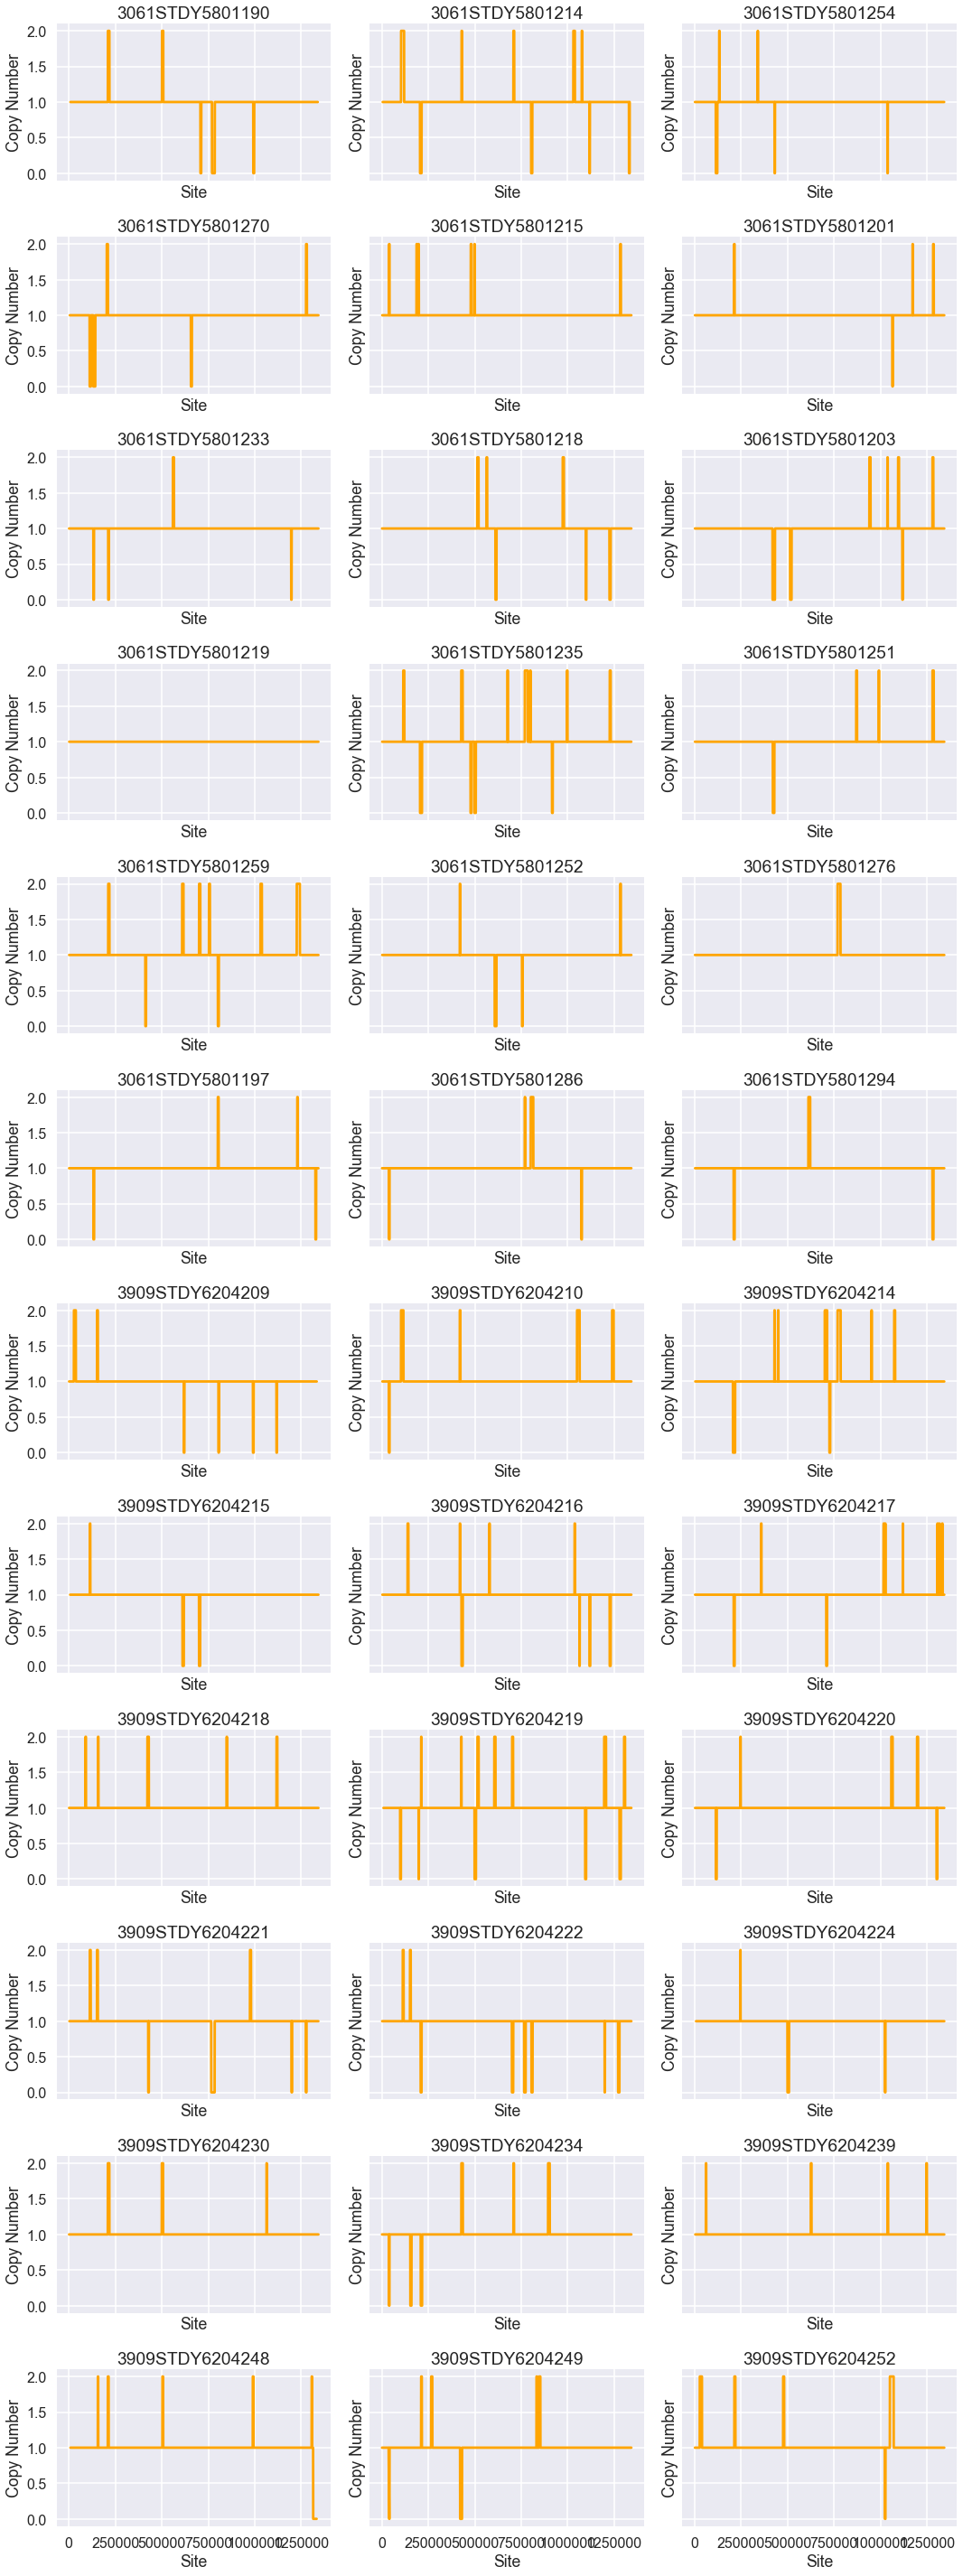

In [106]:
# row and column sharing
# Plot each sample copy number along genome
samples = bothmap["seqscape_name_wgs_Hiseq2000"].unique()
total_samples = len(samples)
total_cols = 3
total_rows =  int(np.ceil(total_samples // total_cols))
fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey='row', figsize=(15, 40))
for row_idx, row in enumerate(axes):  
    for col_idx, ax in enumerate(row):
        sample_idx = (row_idx* total_cols) + col_idx
        if sample_idx >= len(samples):
            break  # No more plots, end of samples
        subset = bothmap[(bothmap["seqscape_name_wgs_Hiseq2000"] == samples[sample_idx]) ].sort_values("window", ascending=True)
        ax.plot(subset["window"], subset["copy_number.xhmm"], color="orange")
#         hi_line, = ax.plot(hi_subset["GC"], hi_subset["NORMALIZED_COVERAGE"], color="blue")

        ax.set_title(samples[sample_idx])
        ax.set_ylabel("Copy Number")
        ax.set_xlabel("Site")
        
# fig.legend(handles=[lo_line, hi_line], 
#            labels=["Lo DNA Threshold Normalized Coverage", "Hi DNA Threshold Normalized Coverage"],
#            loc = "upper center", bbox_to_anchor=(0.5, 1.01) , ncol=1)
plt.tight_layout()
plt.show()

# Normalized Coverage Along Genome

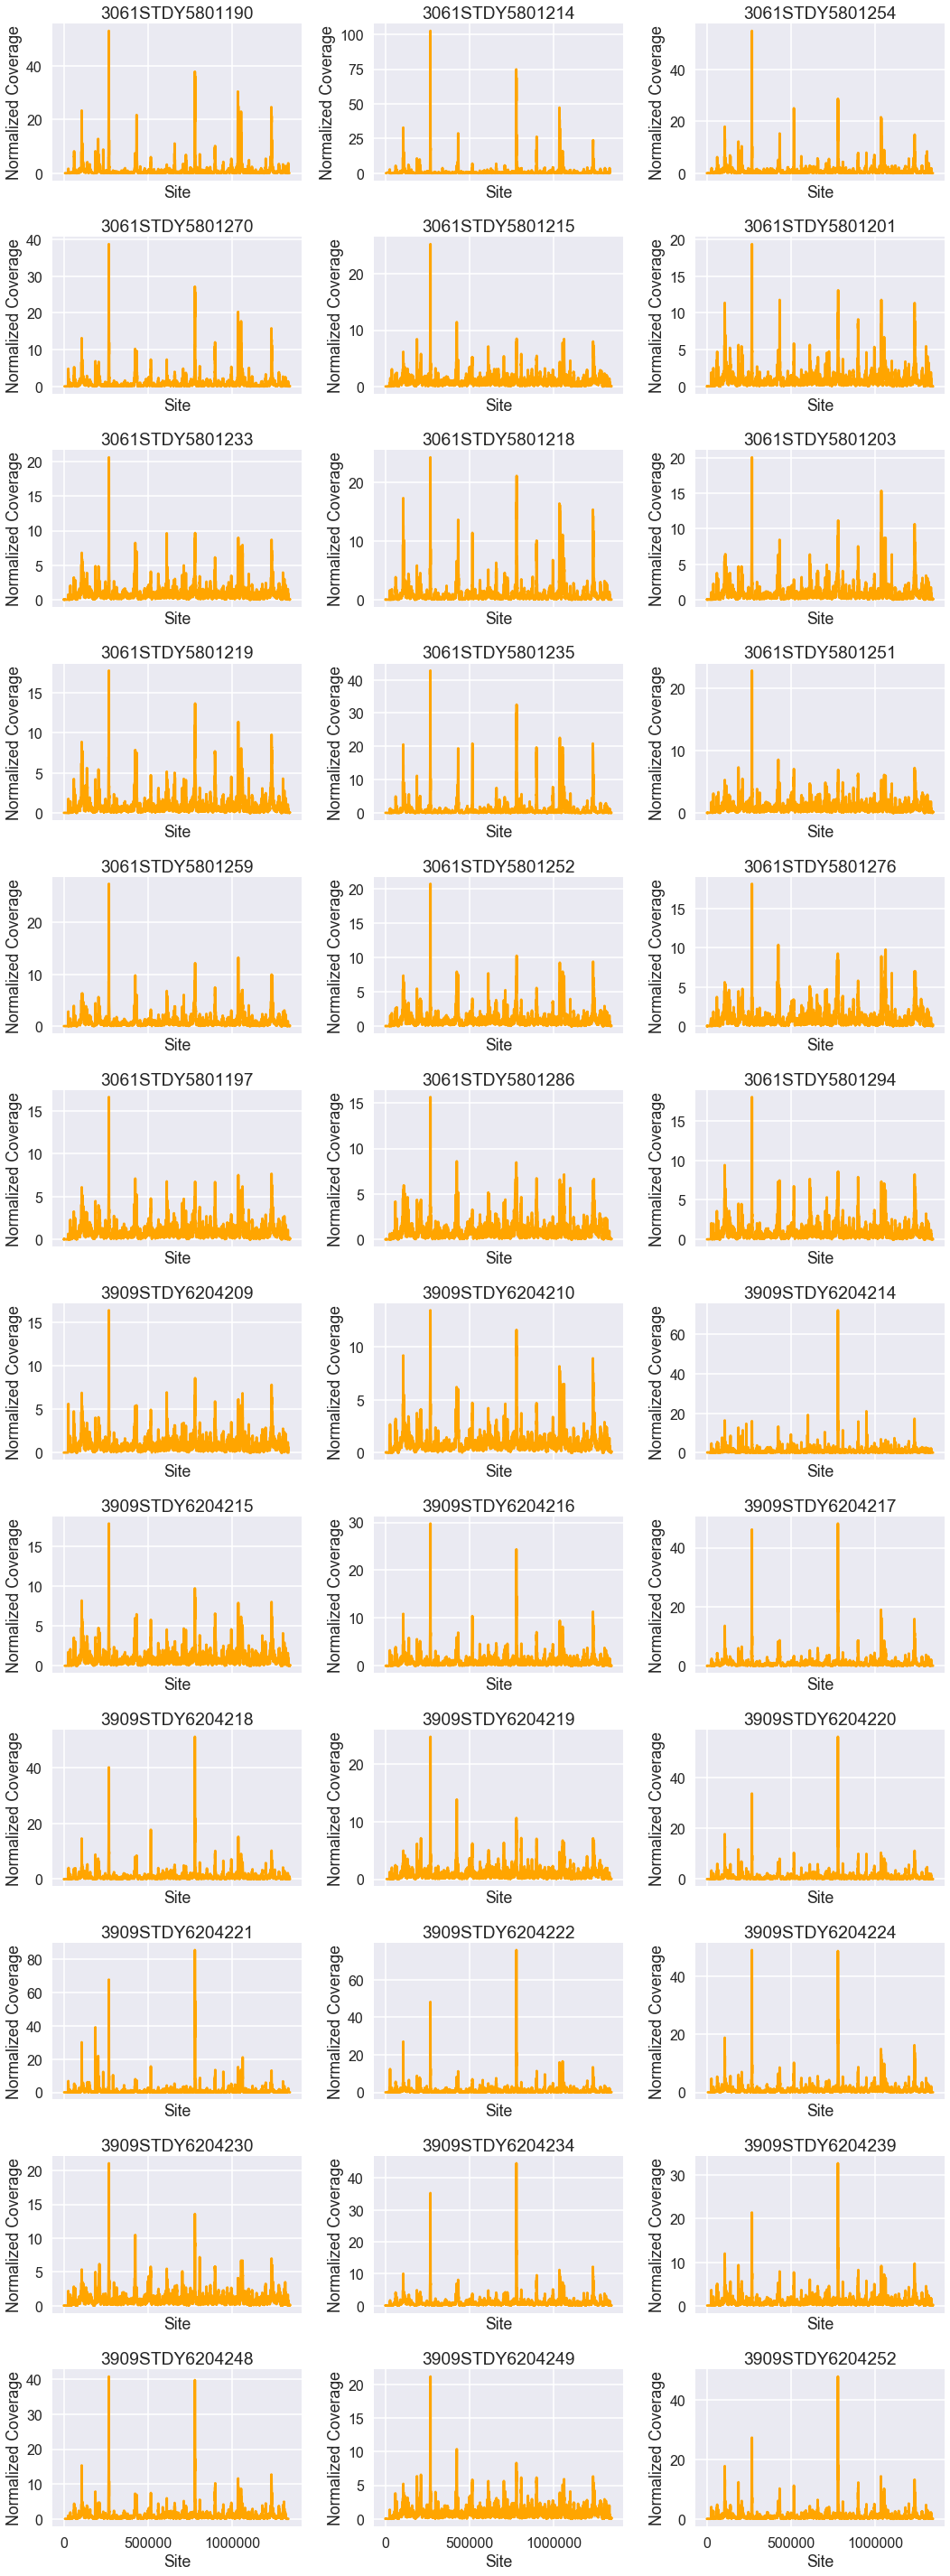

In [104]:
# Plot Normalized Coverage along genome
samples = bothmap["seqscape_name_wgs_Hiseq2000"].unique()
total_samples = len(samples)
total_cols = 3
total_rows =  int(np.ceil(total_samples // total_cols))
fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey=False, figsize=(15, 40))
for row_idx, row in enumerate(axes):  
    for col_idx, ax in enumerate(row):
        sample_idx = (row_idx* total_cols) + col_idx
        if sample_idx >= len(samples):
            break  # No more plots, end of samples
        subset = bothmap[(bothmap["seqscape_name_wgs_Hiseq2000"] == samples[sample_idx]) ].sort_values("window", ascending=True)
        copy_number_line, = ax.plot(subset["window"], subset["norm_reads_all"], color="orange")
#         hi_line, = ax.plot(hi_subset["GC"], hi_subset["NORMALIZED_COVERAGE"], color="blue")

        ax.set_title(samples[sample_idx])
        ax.set_ylabel("Normalized Coverage")
        ax.set_xlabel("Site")
        
# fig.legend(handles=[lo_line, hi_line], 
#            labels=["Lo DNA Threshold Normalized Coverage", "Hi DNA Threshold Normalized Coverage"],
#            loc = "upper center", bbox_to_anchor=(0.5, 1.01) , ncol=1)
plt.tight_layout()
plt.show()

# Raw Coverage Along Genome

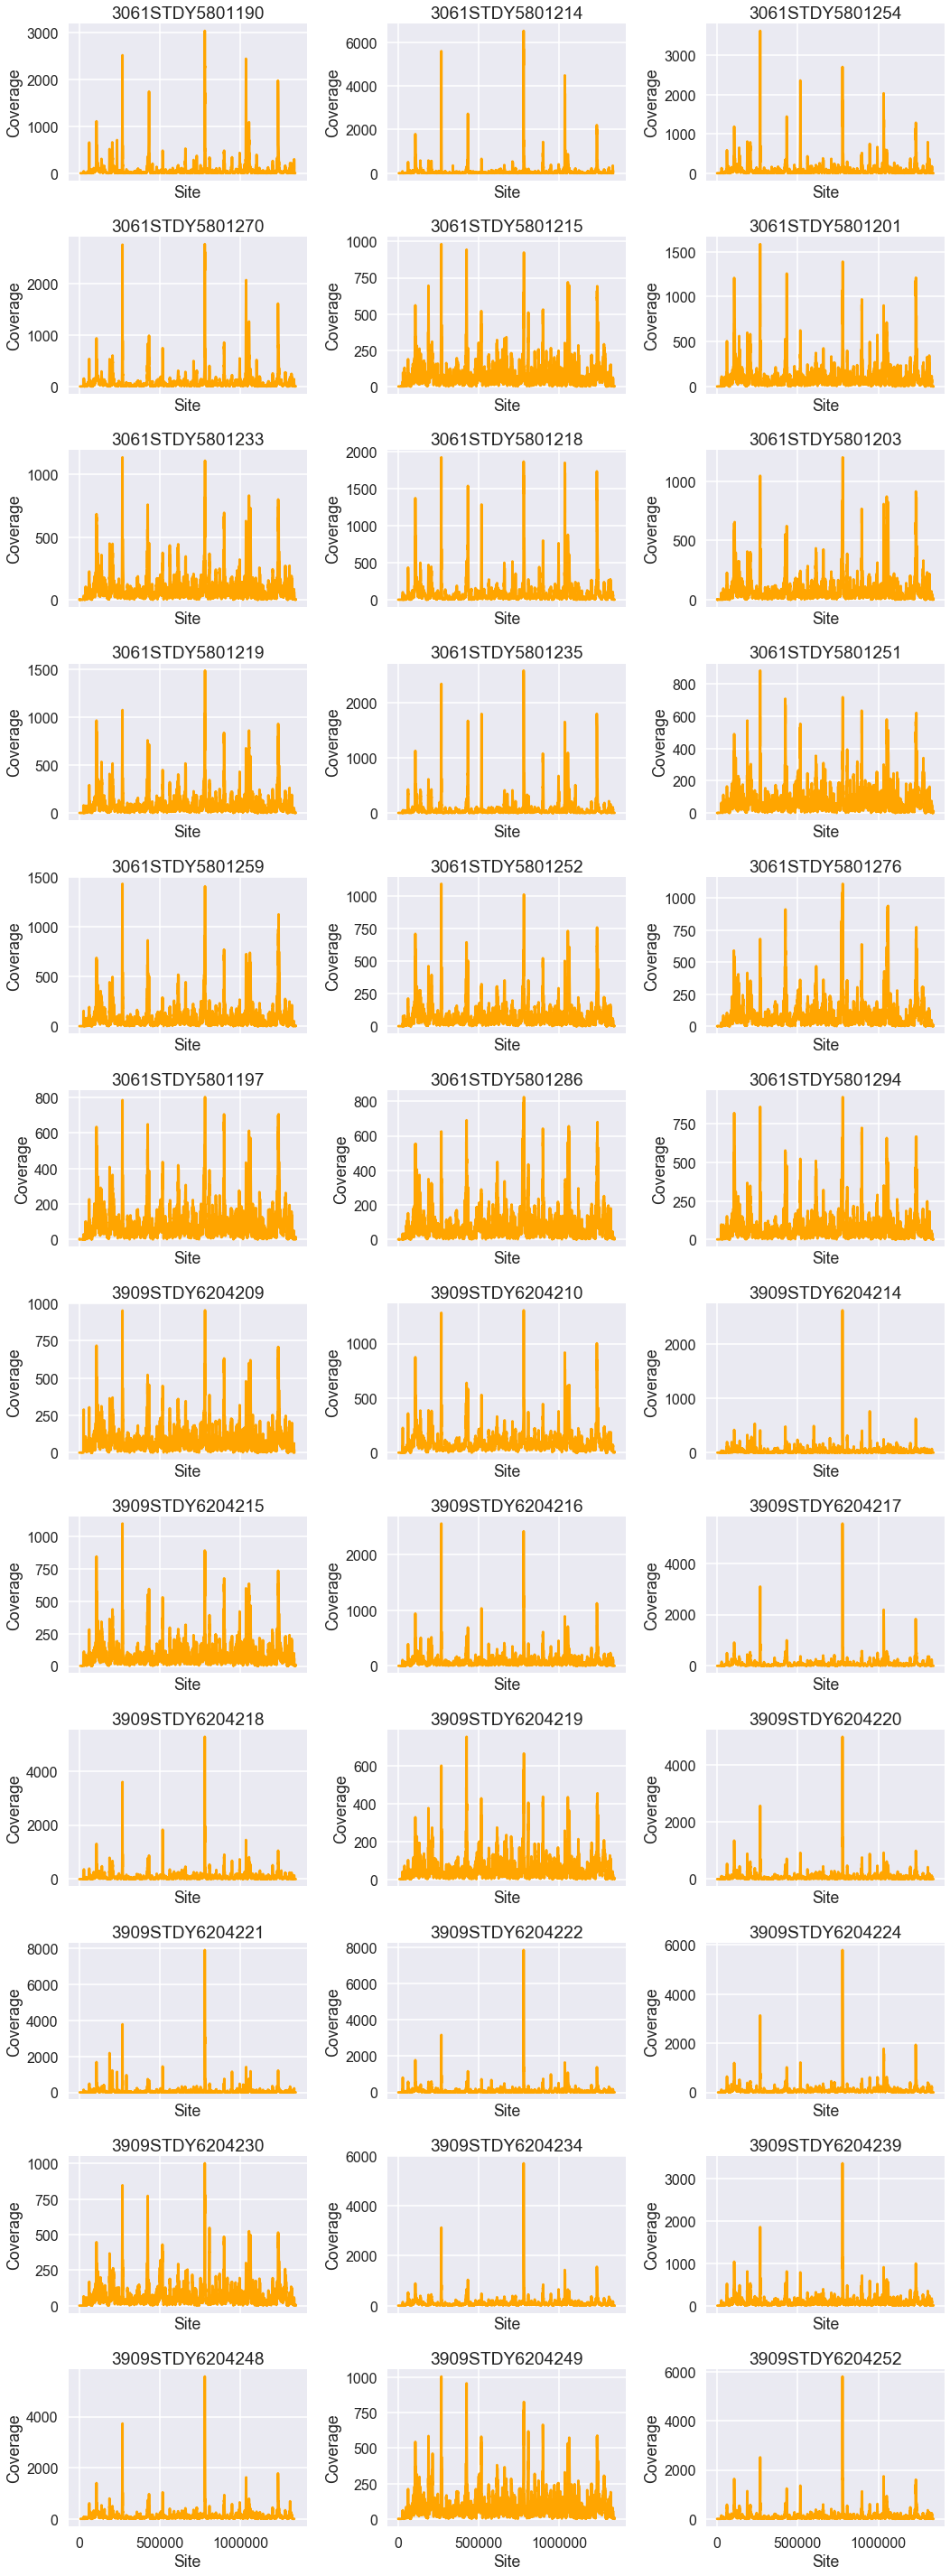

In [105]:
# row and column sharing
# Plot each sample copy number along genome
samples = bothmap["seqscape_name_wgs_Hiseq2000"].unique()
total_samples = len(samples)
total_cols = 3
total_rows =  int(np.ceil(total_samples // total_cols))
fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey=False, figsize=(15, 40))
for row_idx, row in enumerate(axes):  
    for col_idx, ax in enumerate(row):
        sample_idx = (row_idx* total_cols) + col_idx
        if sample_idx >= len(samples):
            break  # No more plots, end of samples
        subset = bothmap[(bothmap["seqscape_name_wgs_Hiseq2000"] == samples[sample_idx]) ].sort_values("window", ascending=True)
        ax.plot(subset["window"], subset["reads_all_win_mean"], color="orange")
#         hi_line, = ax.plot(hi_subset["GC"], hi_subset["NORMALIZED_COVERAGE"], color="blue")

        ax.set_title(samples[sample_idx])
        ax.set_ylabel("Coverage")
        ax.set_xlabel("Site")
        
# fig.legend(handles=[lo_line, hi_line], 
#            labels=["Lo DNA Threshold Normalized Coverage", "Hi DNA Threshold Normalized Coverage"],
#            loc = "upper center", bbox_to_anchor=(0.5, 1.01) , ncol=1)
plt.tight_layout()
plt.show()

In [108]:
xhmm_rd_tsv = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.same_filtered.RD.chr5.txt"

In [158]:
xhmm_rd = pandas.read_csv(xhmm_rd_tsv, sep="\t")
xhmm_rd.head()
xhmm_rd = xhmm_rd.set_index("Matrix")
xhmm_rd.index.name = "Matrix"
xhmm_rd = xhmm_rd.transpose()
xhmm_rd.head()
xhmm_rd = xhmm_rd.reset_index()
xhmm_rd = xhmm_rd.rename(columns={"index": "window"})
xhmm_rd["window"] = xhmm_rd["window"].str.replace("Pf3D7_05_v3:", "")
xhmm_rd["window"] = xhmm_rd["window"].str.split("-").str[0]
xhmm_rd["window"]  = xhmm_rd["window"].astype(np.int)
xhmm_rd["window"] = xhmm_rd["window"] - 1
xhmm_rd.head()

xhmm_rd = xhmm_rd.melt(id_vars="window", value_vars=xhmm_rd.columns.values[1:], var_name="sample", value_name="norm_cov")
xhmm_rd = xhmm_rd.set_index("sample").join(
    sample_map[["oxford_code_swga_X10", "seqscape_name_wgs_Hiseq2000"]].set_index("oxford_code_swga_X10"))
xhmm_rd.loc[pandas.isnull(xhmm_rd["seqscape_name_wgs_Hiseq2000"]), "seqscape_name_wgs_Hiseq2000"] = "3D7_10-T1"
display(xhmm_rd.shape)
display(xhmm_rd.head())
display(xhmm_rd.describe())

(132978, 3)

,window,norm_cov,seqscape_name_wgs_Hiseq2000
3D7_10-T1,27000,53.53,3D7_10-T1
3D7_10-T1,27300,48.87,3D7_10-T1
3D7_10-T1,28200,56.70,3D7_10-T1
3D7_10-T1,28500,34.48,3D7_10-T1
3D7_10-T1,30600,37.56,3D7_10-T1


,window,norm_cov
count,1.329780e+05,132978.000000
mean,6.774124e+05,66.542101
std,3.663394e+05,57.987077
min,2.700000e+04,0.000000
25%,3.633000e+05,25.862500
50%,6.703500e+05,50.120000
75%,9.816000e+05,89.947500
max,1.333500e+06,726.820000


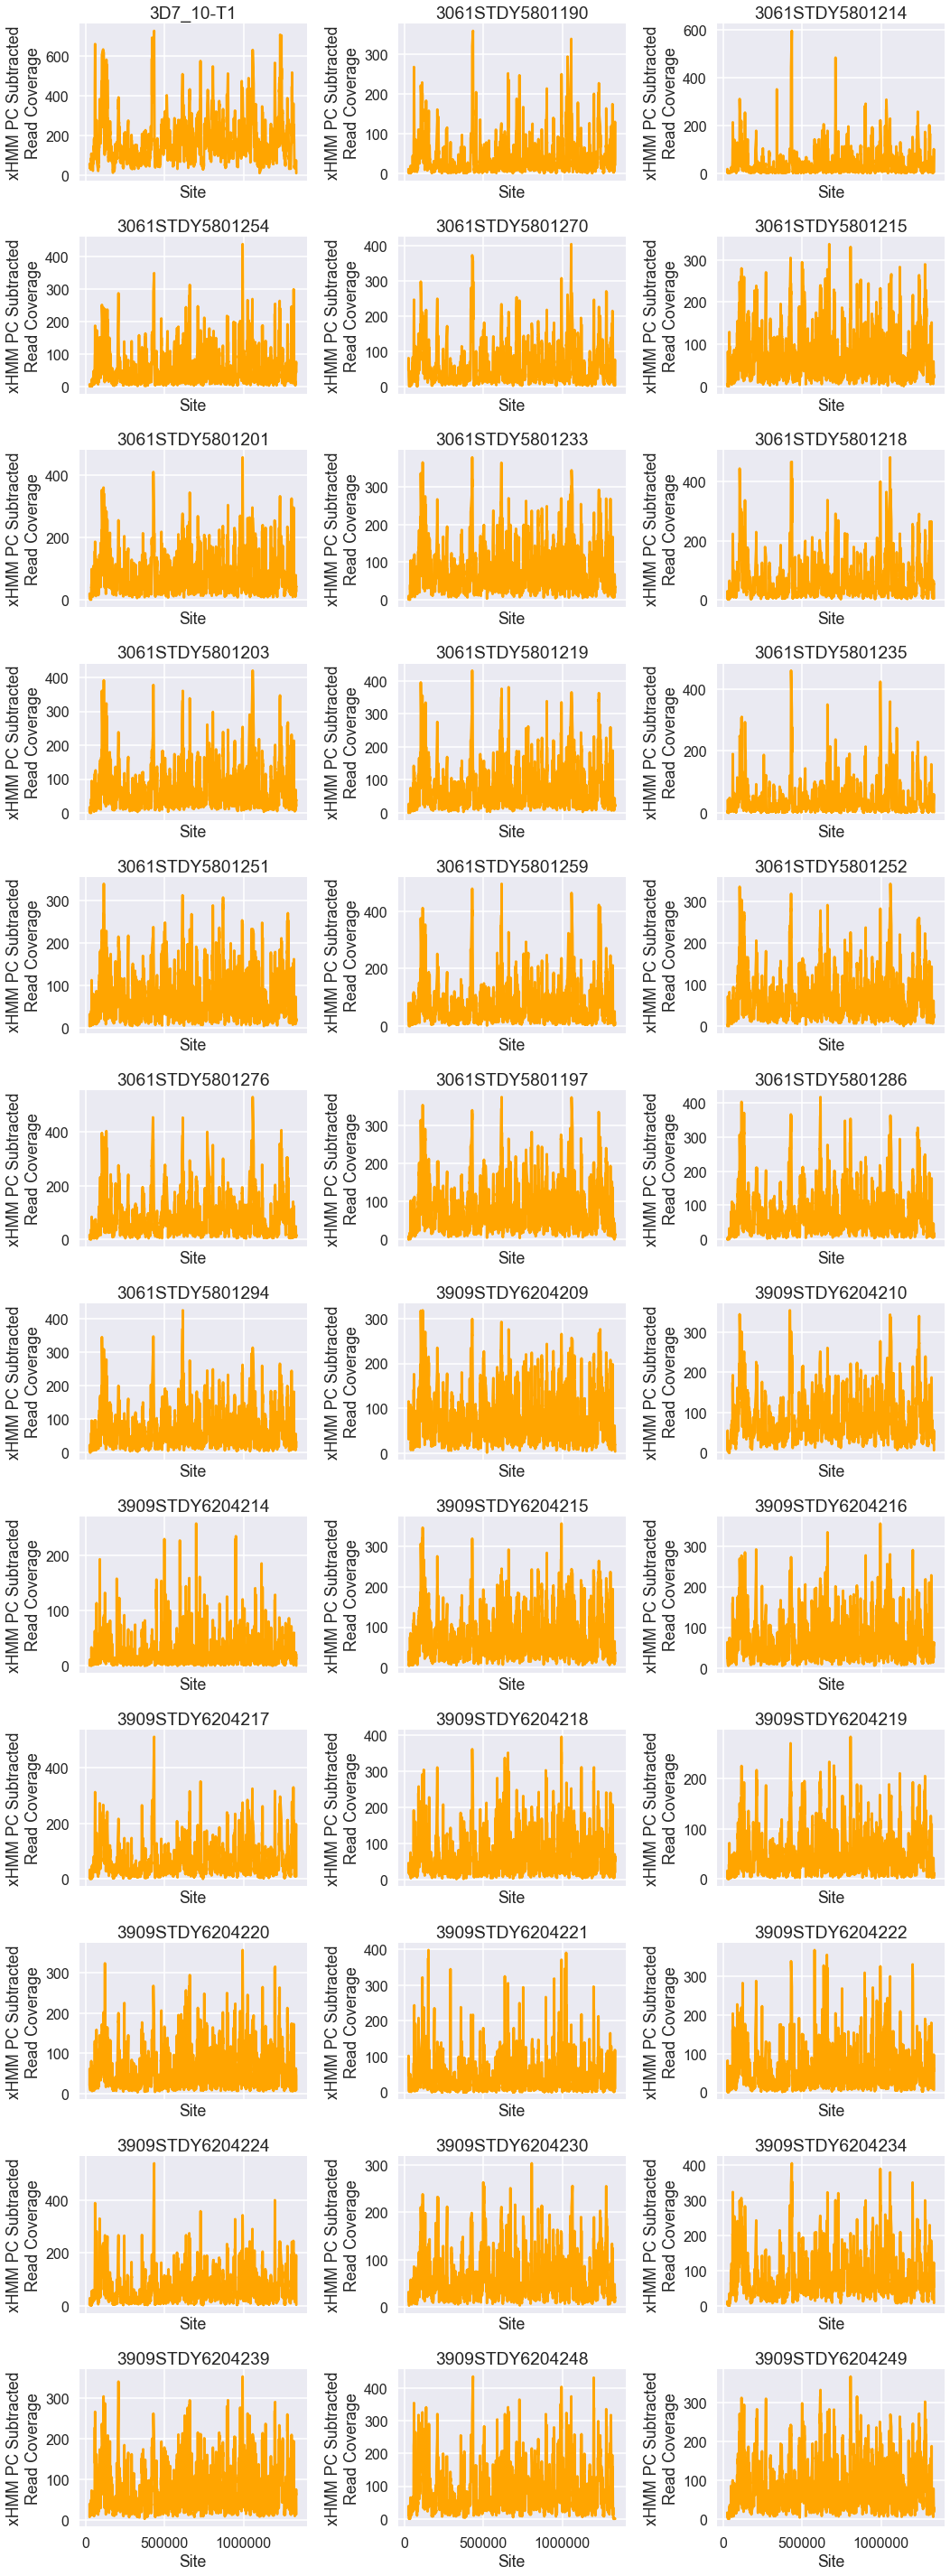

In [161]:
# row and column sharing
# Plot each sample copy number along genome
samples = xhmm_rd["seqscape_name_wgs_Hiseq2000"].unique()
total_samples = len(samples)
total_cols = 3
total_rows =  int(np.ceil(total_samples // total_cols))
fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey=False, figsize=(15, 40))
for row_idx, row in enumerate(axes):  
    for col_idx, ax in enumerate(row):
        sample_idx = (row_idx* total_cols) + col_idx
        if sample_idx >= len(samples):
            break  # No more plots, end of samples
        subset = xhmm_rd[(xhmm_rd["seqscape_name_wgs_Hiseq2000"] == samples[sample_idx]) ].sort_values("window", ascending=True)
        ax.plot(subset["window"], subset["norm_cov"], color="orange")
#         hi_line, = ax.plot(hi_subset["GC"], hi_subset["NORMALIZED_COVERAGE"], color="blue")

        ax.set_title(samples[sample_idx])
        ax.set_ylabel("xHMM PC Subtracted\nRead Coverage")
        ax.set_xlabel("Site")
        
# fig.legend(handles=[lo_line, hi_line], 
#            labels=["Lo DNA Threshold Normalized Coverage", "Hi DNA Threshold Normalized Coverage"],
#            loc = "upper center", bbox_to_anchor=(0.5, 1.01) , ncol=1)
plt.tight_layout()
plt.show()